In [ ]:
# Copyright (c) 2026 Nima Sharifinia
# Licensed under the Apache License, Version 2.0

In [1]:
# import kagglehub
# path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
# print("Path to dataset files:", path)
path = "/home/nima/Downloads"

Imports

In [2]:
# !pip install torch_geometric

In [3]:
import json
import cv2
import numpy as np
# import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import os
import sys
from torchvision import transforms
import re
from collections import defaultdict
import matplotlib.pyplot as plt

# from torch_geometric.nn import GCNConv
# from torch_geometric.data import Data
# from torch_geometric.nn import SAGEConv  # Importing SAGEConv
# from torch_geometric.nn import GraphConv
# from torch_geometric.nn import global_mean_pool

# Dataset

In [4]:
BATCH_SIZE = 256
feature_extraction_model = "xception"

Builiding vocab and tokenizer

In [5]:
class CustomTokenizer:
    def __init__(self, num_words=None, oov_token="<unk>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.max_length = 0
        self.word_to_idx = {}
        self.idx_to_word = {}

    def clean_text(self, text):
        # Convert to lowercase and remove punctuation (except spaces)
        text = text.lower()
        text = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~]', '', text)
        return text

    def fit_on_texts(self, texts):
        word_counts = {}

        # Split sentences into words correctly
        for text in texts:
            cleaned_text = self.clean_text(text)  # Proper cleaning
            words = cleaned_text.split()  # Split sentence into words
            if self.max_length < len(words):
              self.max_length = len(words)
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1

        # Sort words by frequency
        sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

        # Limit vocab to num_words (excluding OOV)
        vocab_size = self.num_words - 1 if self.num_words else len(sorted_vocab)

        # Build the word_to_idx and idx_to_word dictionaries
        self.word_to_idx = {
            "<pad>": 0,
            "<unk>": 1,
        }
        self.idx_to_word = {
            0: "<pad>",
            1: "<unk>",
        }

        for idx, (word, _) in enumerate(sorted_vocab[:vocab_size], start=2):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word

    def text_to_sequence(self, text):
        cleaned_text = self.clean_text(text)
        words = cleaned_text.split()  # Ensure proper tokenization
        return [self.word_to_idx.get(word, self.word_to_idx["<unk>"]) for word in words]  # Map to index
    
    def decode(self, tokens):
        words = []
        for idx in tokens:
            word = self.idx_to_word.get(idx, "<unk>")
            if word == self.word_to_idx["<end>"]:
                break
            words.append(word)
        return ' '.join(words)



tokenizer = CustomTokenizer(num_words=5000, oov_token="<unk>")

COCO Dataset


In [6]:
import os.path
class CocoDataSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_captions = []
        self.all_images = []
        self.all_ids = []
        self.all_refs = defaultdict(list)
        self.max_length = 0
        self.PATH = f"{path}/coco2017/train2017/"

        # Load annotations
        with open(f'{path}/coco2017/annotations/captions_train2017.json', 'r') as file:
            data = json.load(file)

        # Create an image index
        image_id_index = {}
        for img in data['images']:
            image_id_index[img['id']] = img['file_name']

        for annot in data['annotations']:
            self.all_refs[annot["image_id"]].append(annot["caption"])
            caption = '<start> ' + annot['caption'] + ' <end>'
            image_id = annot['image_id']
            full_coco_image_path = self.PATH + image_id_index[image_id]
            if not image_id in self.all_ids:
                self.all_ids.append(image_id)
                self.all_images.append(full_coco_image_path)
                self.all_captions.append(caption)

    def encode(self, caption):
        caption = tokenizer.clean_text(caption)
        encoded_caption = tokenizer.text_to_sequence(caption)
        remain = tokenizer.max_length - len(encoded_caption)
        for i in range(remain):
            encoded_caption.append(0)

        return torch.tensor(encoded_caption)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.all_captions)

    def __getitem__(self, idx):
        """Fetches the image and encoded caption at the specified index."""
        image_name = self.all_images[idx]

        img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
        reltr_features = np.load(image_name + "_reltr.npy")

        # Get the corresponding caption
        caption = self.all_captions[idx]

        # One-hot encode the caption
        encoded_caption = self.encode(caption)

        return img_features, reltr_features, caption, encoded_caption

# Example usage
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure 3 channels (convert grayscale to RGB)
    transforms.ToTensor(),
])

# Create the custom dataset
dataset = CocoDataSet(transform=transform)
dataset_len = len(dataset)

tokenizer = CustomTokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(dataset.all_captions)

In [7]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [8]:
class CocoValDataSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_captions = []
        self.all_images = []
        self.all_ids = []
        self.max_length = 0
        self.PATH = f"{path}/coco2017/val2017/"

        # Load annotations
        with open(f'{path}/coco2017/annotations/captions_val2017.json', 'r') as file:
            data = json.load(file)

        # Create an image index
        image_id_index = {}
        for img in data['images']:
            image_id_index[img['id']] = img['file_name']

        for annot in data['annotations']:
            caption = '<start> ' + annot['caption'] + ' <end>'
            image_id = annot['image_id']
            if not image_id in self.all_ids:
              full_coco_image_path = self.PATH + image_id_index[image_id]
              self.all_ids.append(image_id)
              self.all_images.append(full_coco_image_path)
              self.all_captions.append(caption)

    def encode(self, caption):
        caption = tokenizer.clean_text(caption)
        encoded_caption = tokenizer.text_to_sequence(caption)
        remain = tokenizer.max_length - len(encoded_caption)
        for i in range(remain):
            encoded_caption.append(0)

        return torch.tensor(encoded_caption)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.all_captions)

    def __getitem__(self, idx):
        """Fetches the image and one-hot encoded caption at the specified index."""
        image_name = self.all_images[idx]

        # Load image features
        img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
        reltr_features = np.load(image_name + "_reltr.npy")

        # Get the corresponding caption
        caption = self.all_captions[idx]

        # One-hot encode the caption
        encoded_caption = self.encode(caption)

        return image_name, img_features, reltr_features, encoded_caption

val_dataset = CocoValDataSet(transform=transform)
val_dataset_len = len(val_dataset)

Dataloader

In [9]:
from torch.utils.data import Subset

# train_size = int(0.8 * len(dataset))
# test_size = int(len(dataset) - train_size)

# test_dataset = Subset(dataset, range(train_size, len(dataset)))
# dataset = Subset(dataset, range(0, train_size))

In [10]:
from torch.utils.data import DataLoader
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Encoder and Decoder

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, embedding_dim).to(device)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(0)
        x = x + self.pe[:T].unsqueeze(1)
        return self.dropout(x)

class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, nheads=8, num_layers=6, dim_ff=2048, dropout=0.1, pad_idx=0):
        super().__init__()
        self.d_model = d_model
        self.pad_idx = pad_idx

        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_enc = PositionalEncoding(d_model, max_len=tokenizer.max_length, dropout=dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nheads, dim_feedforward=dim_ff, dropout=dropout, batch_first=False
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.out = nn.Linear(d_model, vocab_size)
        self.out.weight = self.tok_emb.weight  # tie weights

    def forward(self, tgt_tokens, memory, tgt_key_padding_mask=None):
        # tgt_tokens: (T, B)
        tgt_emb = self.tok_emb(tgt_tokens) * math.sqrt(self.d_model)
        tgt_emb = self.pos_enc(tgt_emb)

        T = tgt_tokens.size(0)
        causal_mask = torch.triu(torch.ones(T, T, device=tgt_tokens.device), diagonal=1).bool()

        dec_out = self.decoder(
            tgt=tgt_emb,
            memory=memory,  # (S=101, B, E)
            tgt_mask=causal_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        logits = self.out(dec_out)  # (T, B, V)
        return logits



### Image Captioner Model

In [13]:
class ImageCaptioner(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode_image(self, img_feats):
        # img_feats: (B, 101, input_dim)
        mem = self.encoder(img_feats)         # (B, 101, d_model)
        mem = mem.transpose(0, 1)              # (S=101, B, d_model)
        return mem

    def forward(self, img_feats, tgt_tokens, tgt_key_padding_mask=None):
        memory = self.encode_image(img_feats)
        logits = self.decoder(tgt_tokens, memory, tgt_key_padding_mask)
        return logits


In [14]:
def make_tgt_inputs(target_seqs, pad_idx, eos_idx):
    """
    target_seqs: (B, L=51) with <start> at pos 0 and <end> somewhere before padding.
    pad_idx: index of <pad>
    eos_idx: index of <end>
    """
    # Shift for teacher forcing
    dec_inp = target_seqs[:, :-1]   # remove last token
    dec_tgt = target_seqs[:, 1:]    # remove first token

    # Replace anything after <end> in dec_tgt with pad_idx
    # so model is not trained to predict random tokens after EOS.
    for i in range(dec_tgt.size(0)):
        eos_pos = (dec_tgt[i] == eos_idx).nonzero(as_tuple=True)[0]
        if len(eos_pos) > 0:
            first_eos = eos_pos[0].item()
            if first_eos + 1 < dec_tgt.size(1):
                dec_tgt[i, first_eos+1:] = pad_idx

    # Transpose to (T, B) for transformer
    dec_inp = dec_inp.transpose(0, 1)
    dec_tgt = dec_tgt.transpose(0, 1)

    # Padding mask for the decoder: True where PAD
    tgt_key_padding_mask = (dec_inp.transpose(0, 1) == pad_idx)  # (B, T)

    return dec_inp, dec_tgt, tgt_key_padding_mask



### Hyper Parameters

In [15]:
vocab_size = len(tokenizer.word_to_idx)
input_dim = 2048  # feature vector size per region
d_model = 256
nheads = 8
num_layers = 8
dropout = 0.3

encoder = CNN_Encoder(input_dim=input_dim, embedding_dim=d_model).to(device)
decoder = CaptionDecoder(vocab_size=vocab_size, d_model=d_model, nheads=nheads, num_layers=num_layers, dropout=dropout, pad_idx=tokenizer.word_to_idx["<pad>"]).to(device)

model = ImageCaptioner(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx["<pad>"], label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)


In [20]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch, (img_feats, reltr_feats, _, enc_caps) in enumerate(dataloader):
        img_feats = img_feats.float().to(device)  # (B, 102, 2048)
        reltr_feats = reltr_feats.float().to(device)
        feats = torch.cat((img_feats, reltr_feats.squeeze(1)), dim=1).to(device)

        enc_caps = enc_caps.long().to(device)     # (B, 51)

        dec_inp, dec_tgt, pad_mask = make_tgt_inputs(enc_caps, tokenizer.word_to_idx["<pad>"], tokenizer.word_to_idx["<end>"])

        logits = model(feats, dec_inp, pad_mask)  # (T=50, B, V)

        loss = criterion(logits.reshape(-1, logits.size(-1)), dec_tgt.reshape(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    for batch in dataloader:
        img_feats, reltr_feats, _, enc_caps = batch
        

        img_feats = img_feats.float().to(device)  # (B, 102, 2048)
        reltr_feats = reltr_feats.float().to(device)
        feats = torch.cat((img_feats, reltr_feats.squeeze(1)), dim=1).to(device)
        enc_caps = enc_caps.long().to(device)

        dec_inp, dec_tgt, pad_mask = make_tgt_inputs(enc_caps, tokenizer.word_to_idx["<pad>"], tokenizer.word_to_idx["<end>"])
        logits = model(feats, dec_inp, pad_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), dec_tgt.reshape(-1))
        total_loss += float(loss.item())
    return total_loss / max(1, len(dataloader))


In [21]:
def decode_tokens(token_ids, tokenizer, eos_idx):
    words = []
    for idx in token_ids:
        if idx == eos_idx:
            break
        if idx in tokenizer.idx_to_word:
            w = tokenizer.idx_to_word[idx]
            if w not in ("<start>", "<pad>"):
                words.append(w)
        else:
            words.append("<unk>")
    return " ".join(words)

@torch.no_grad()
def generate_caption(model, img_feats, reltr_feats, tokenizer, max_len=51, device="cuda", temperature=1.0):
    model.eval()
    img_feats = torch.from_numpy(img_feats).float().unsqueeze(0).to(device)
    reltr_feats = torch.from_numpy(reltr_feats).float().to(device)
    feats = torch.cat((img_feats, reltr_feats), dim=1).to(device)

    memory = model.encode_image(feats)

    PAD_IDX = tokenizer.word_to_idx["<pad>"]
    BOS_IDX = tokenizer.word_to_idx["<start>"]
    EOS_IDX = tokenizer.word_to_idx["<end>"]

    ys = torch.tensor([[BOS_IDX]], dtype=torch.long, device=device)  # (1, 1)

    for _ in range(max_len - 1):
        tgt_key_padding_mask = (ys.transpose(0, 1) == PAD_IDX)  # (1, T)

        # Call full forward pass of decoder (already includes self.out)
        logits = model.decoder(ys, memory, tgt_key_padding_mask)  # (T, 1, vocab_size)

        next_token_logits = logits[-1, 0, :]  # Last timestep's vocab scores
        
        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature
        
        # Convert logits to probabilities
        probs = F.softmax(next_token_logits, dim=-1)
        
        # Sample the next token (instead of using argmax)
        next_id = torch.multinomial(probs, 1).item()

        ys = torch.cat([ys, torch.tensor([[next_id]], device=device)], dim=0)

        if next_id == EOS_IDX:
            break

    pred_ids = ys.squeeze(1).tolist()
    caption = decode_tokens(pred_ids, tokenizer, EOS_IDX)
    return caption

In [18]:
# best_val_loss = float('inf')
# best_model = None
# EPOCHS = 40
# loss_plot = []
# val_loss_plot = []

# for epoch in range(1, EPOCHS+1):
#     tr_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
#     val_loss = evaluate(model, val_dataloader, criterion, device)
#     loss_plot.append(tr_loss)
#     val_loss_plot.append(val_loss)
    
#     print(f"Epoch {epoch:02d} | train CE: {tr_loss:.3f} | val CE: {val_loss:.3f}")

#     image_name, img_feats, reltr_feats, _ = val_dataset[1]

#     caption = generate_caption(model, img_feats, reltr_feats, tokenizer, max_len=tokenizer.max_length, device=device, temperature=0.5)
#     print("Generated caption:", caption)
    
#     scheduler.step(val_loss)

    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model_state = model.state_dict()
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': best_model_state,
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': val_loss,
#         }, 'best_model.pth')
#         print(f"Model saved at epoch {epoch}")


In [22]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

EPOCHS = 40
results = []

for fold, (train_idx, fold_val_idx) in enumerate(kf.split(dataset)):
    print(f"\n--- FOLD {fold+1}/{k} ---")
    print("="*30)

    # Create subsets
    fold_train = Subset(dataset, train_idx)
    fold_val   = Subset(dataset, fold_val_idx)

    # DataLoaders
    train_loader = DataLoader(fold_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    fold_val_loader = DataLoader(fold_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

    # Re-initialize model + optimizer for each fold
    encoder = CNN_Encoder(input_dim=input_dim, embedding_dim=d_model).to(device)
    decoder = CaptionDecoder(vocab_size=vocab_size, d_model=d_model, nheads=nheads, num_layers=num_layers, dropout=dropout, pad_idx=tokenizer.word_to_idx["<pad>"]).to(device)

    model = ImageCaptioner(encoder, decoder).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx["<pad>"], label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    best_model_state = None
    loss_plot, val_loss_plot = [], []

    # Train for EPOCHS
    for epoch in range(1, EPOCHS+1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        fold_val_loss = evaluate(model, fold_val_loader, criterion, device)

        loss_plot.append(tr_loss)
        val_loss_plot.append(fold_val_loss)

        print(f"[Fold {fold+1}] Epoch {epoch:02d} | train CE: {tr_loss:.3f} | fold-val CE: {fold_val_loss:.3f}")

        scheduler.step(fold_val_loss)

        # Save best fold model
        if fold_val_loss < best_val_loss:
            best_val_loss = fold_val_loss
            best_model_state = model.state_dict()
            torch.save({
                'fold': fold,
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': fold_val_loss,
            }, f'best_model_fold{fold+1}.pth')

    results.append(best_val_loss)



--- FOLD 1/5 ---
[Fold 1] Epoch 01 | train CE: 23.512 | fold-val CE: 11.402
[Fold 1] Epoch 02 | train CE: 9.856 | fold-val CE: 7.281
[Fold 1] Epoch 03 | train CE: 7.112 | fold-val CE: 6.208
[Fold 1] Epoch 04 | train CE: 6.256 | fold-val CE: 5.771
[Fold 1] Epoch 05 | train CE: 5.794 | fold-val CE: 5.822
[Fold 1] Epoch 06 | train CE: 5.571 | fold-val CE: 6.009
[Fold 1] Epoch 07 | train CE: 5.434 | fold-val CE: 6.123
[Fold 1] Epoch 08 | train CE: 5.323 | fold-val CE: 6.385
[Fold 1] Epoch 09 | train CE: 5.275 | fold-val CE: 6.559
[Fold 1] Epoch 10 | train CE: 5.236 | fold-val CE: 6.604
[Fold 1] Epoch 11 | train CE: 5.190 | fold-val CE: 6.568
[Fold 1] Epoch 12 | train CE: 5.172 | fold-val CE: 6.479
[Fold 1] Epoch 13 | train CE: 5.131 | fold-val CE: 6.289
[Fold 1] Epoch 14 | train CE: 5.057 | fold-val CE: 6.129
[Fold 1] Epoch 15 | train CE: 5.024 | fold-val CE: 5.963
[Fold 1] Epoch 16 | train CE: 5.000 | fold-val CE: 5.987
[Fold 1] Epoch 17 | train CE: 4.981 | fold-val CE: 5.900
[Fold 1] Ep

In [43]:
checkpoint = torch.load('best_model_fold1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
val_loss = checkpoint['loss']

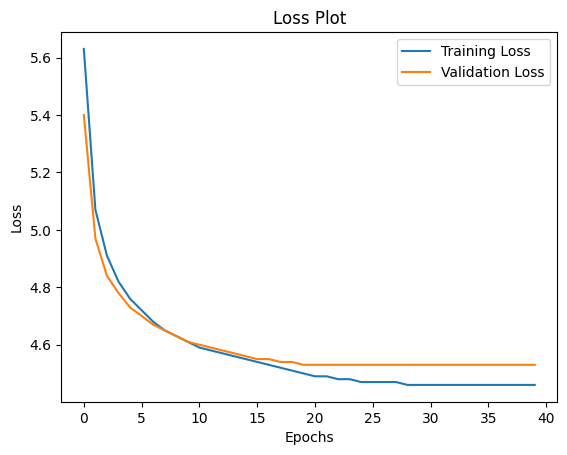

In [52]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [31]:
# Pick a sample from validation set
image_name, img_feats, reltr_feats, _ = val_dataset[101]

caption = generate_caption(model, img_feats, reltr_feats, tokenizer, max_len=51, device=device, temperature=0.1)
print("Image:", image_name)
print("Generated caption:", caption)


Image: /home/nima/Downloads/coco2017/val2017/000000571857.jpg
Generated caption: a group of people sitting on top of a sandy beach


In [ ]:
image_name = "/home/nima/Downloads/coco2017/train2017/000000314700.jpg"

img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
reltr_features = np.load(image_name + "_reltr.npy")

caption = generate_caption(model, img_features, reltr_features, tokenizer, tokenizer.max_length, device, temperature=0.1)
print(image_name)
print(caption)

/home/nima/Downloads/coco2017/train2017/000000314700.jpg
a woman is holding a cell phone in her hands


In [ ]:
# !pip install nltk rouge-score pycocoevalcap

In [ ]:
import json

# Containers for COCO-style ground truth and predictions
annotations = []
images = []
results = []

ann_id = 0
total = len(test_dataset)
# total = 5000

for i, index in enumerate(test_dataset.indices):
    # Unpack data
    img_features, reltr_features, caption, encoded_caption = test_dataset[i]
    image_id = test_dataset.dataset.all_ids[index]

    # Generate model prediction
    generated_caption = generate_caption(
        model, img_features, reltr_features,
        tokenizer, max_len=tokenizer.max_length,
        device=device, temperature=0.1
    )

    # Append to ground truth annotations
    for ref_caption in test_dataset.dataset.all_refs[image_id]:
        annotations.append({
            "image_id": image_id,
            "id": ann_id,
            "caption": ref_caption
        })
        ann_id += 1

    # Append to predictions
    results.append({
        "image_id": image_id,
        "caption": generated_caption
    })

    # Track image IDs
    images.append({"id": image_id})

    print(f"{i+1}/{total}")
    if i+1 == total:
        break

# Save predictions to results.json
with open("results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

# Save ground truth to annotations.json
coco_gt = {
    "images": images,
    "annotations": annotations
}
with open("annotations.json", "w", encoding="utf-8") as f:
    json.dump(coco_gt, f, indent=2)

print("✅ Saved results.json and annotations.json")

In [44]:
total = len(val_dataset)
file = open("results.json", "a")  # append mode
file.write("[")
for i, (img_name, img_features, reltr_features, encoded_caption) in enumerate(val_dataset):
  generated_caption = generate_caption(model, img_features, reltr_features, tokenizer, max_len=tokenizer.max_length, device=device, temperature=0.1)
  obj = {"image_id": val_dataset.all_ids[i], "caption": generated_caption}
  file.write(json.dumps(obj))
  if i + 1 != total:
    file.write(",")
  print(f"{i+1}/{total}")
file.write("]")
file.close()

1/5000
2/5000
3/5000
4/5000
5/5000
6/5000
7/5000
8/5000
9/5000
10/5000
11/5000
12/5000
13/5000
14/5000
15/5000
16/5000
17/5000
18/5000
19/5000
20/5000
21/5000
22/5000
23/5000
24/5000
25/5000
26/5000
27/5000
28/5000
29/5000
30/5000
31/5000
32/5000
33/5000
34/5000
35/5000
36/5000
37/5000
38/5000
39/5000
40/5000
41/5000
42/5000
43/5000
44/5000
45/5000
46/5000
47/5000
48/5000
49/5000
50/5000
51/5000
52/5000
53/5000
54/5000
55/5000
56/5000
57/5000
58/5000
59/5000
60/5000
61/5000
62/5000
63/5000
64/5000
65/5000
66/5000
67/5000
68/5000
69/5000
70/5000
71/5000
72/5000
73/5000
74/5000
75/5000
76/5000
77/5000
78/5000
79/5000
80/5000
81/5000
82/5000
83/5000
84/5000
85/5000
86/5000
87/5000
88/5000
89/5000
90/5000
91/5000
92/5000
93/5000
94/5000
95/5000
96/5000
97/5000
98/5000
99/5000
100/5000
101/5000
102/5000
103/5000
104/5000
105/5000
106/5000
107/5000
108/5000
109/5000
110/5000
111/5000
112/5000
113/5000
114/5000
115/5000
116/5000
117/5000
118/5000
119/5000
120/5000
121/5000
122/5000
123/5000
1

In [45]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotation_file = f'{path}/coco2017/annotations/captions_val2017.json'
# results_file = 'captions_val2017_fakecap_results.json'

# annotation_file = './annotations.json'
results_file = './results.json'

# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

# evaluate on a subset of images by setting
# coco_eval.params['image_id'] = coco_result.getImgIds()
# please remove this line when evaluating the full validation set
# coco_eval.params['image_id'] = coco_result.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 307315 tokens at 3232793.97 tokens per second.
PTBTokenizer tokenized 76014 tokens at 1492033.13 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 71015, 'reflen': 52597, 'guess': [71015, 66015, 61015, 56015], 'correct': [27795, 11844, 3841, 1173]}
ratio: 1.3501720630453953
Bleu_1: 0.391
Bleu_2: 0.265
Bleu_3: 0.164
Bleu_4: 0.098
computing METEOR score...
METEOR: 0.164
computing Rouge score...
ROUGE_L: 0.407
computing CIDEr score...
CIDEr: 0.354
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.1 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.2

SPICE evaluation took: 40.53 s
SPICE: 0.113
Bleu_1: 0.391
Bleu_2: 0.265
Bleu_3: 0.164
Bleu_4: 0.098
METEOR: 0.164
ROUGE_L: 0.407
CIDEr: 0.354
SPICE: 0.113
